In [7]:
from utils import *

In [175]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import cPickle as pickle
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import interp
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier

In [165]:
def cross_val_roc(classifier, X, y, n_splits=3, balance=False, test_size=0.25):
    # Run classifier with cross-validation and plot ROC curves
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    lw = 2
    
    if balance:
        splits = StratifiedShuffleSplit(y, n_splits, test_size=test_size)
    else:
        splits = StratifiedKFold(n_splits=n_splits).split(X, y)
    
    i = 0
    for (train, test), color in zip(splits, colors):
        X_train, X_test = X.ix[train], X.ix[test]
        y_train, y_test = y.ix[train], y.ix[test]
        if balance:
            X_train, y_train = balance_train_index(X_train, y_train)
        
        probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

def cv_score(clf, X, y, cv=5, scoring='f1'):
    print scoring + ' cross validation score: ' + str(np.mean(cross_val_score(rf, X, y, cv=cv, scoring=scoring)))
    
def combine_and_balance_dfs(df1, df2, ignore_index=True):
    if df1.shape[0] < df2.shape[0]:
        return df1.append(df2.sample(df1.shape[0]), ignore_index=ignore_index)
    return df2.append(df1.sample(df2.shape[0]), ignore_index=ignore_index)

def balance_train_index(X_train, y_train):
    pos_index = y_train[y_train == 1].index
    neg_index = y_train[y_train == 0].index
    reduced_neg_index = np.random.choice(neg_index, pos_index.shape[0], replace=False)
    b_index = pos_index.tolist() + reduced_neg_index.tolist()
    return X_train.ix[b_index], y_train.ix[b_index]

In [4]:
with open('pickles/non_allergen_df.pkl', 'r') as fin:
    non_allergen_df = pickle.load(fin)
with open('pickles/allergen_df.pkl', 'r') as fin:
    allergen_df = pickle.load(fin)

In [167]:
allergen_df['allergen'] = 1
non_allergen_df['allergen'] = 0
balanced_df = combine_and_balance_dfs(allergen_df, non_allergen_df)
df = allergen_df.append(non_allergen_df, ignore_index=True)

In [168]:
balanced_df = add_protein_characteristics(balanced_df)
df = add_protein_characteristics(df)

In [169]:
sdf = df.sample(50000).reset_index(drop=True)
print df[df['allergen'] == 1].shape[0]*1.0/(df[df['allergen'] == 0].shape[0] + df[df['allergen'] == 1].shape[0])
print sdf[sdf['allergen'] == 1].shape[0]*1.0/(sdf[sdf['allergen'] == 0].shape[0] + sdf[sdf['allergen'] == 1].shape[0])

0.00378274519223
0.00368


## balanced versus unbalanced training

f1 cross validation score: 0.860288936304


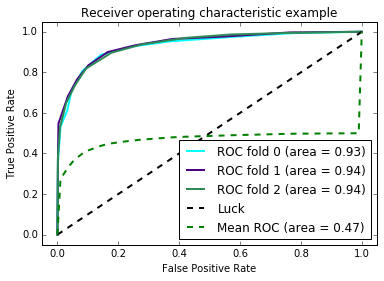

In [170]:
X = balanced_df.drop(['sequence','allergen'], axis=1)
y = balanced_df['allergen']
rf = RandomForestClassifier()
cross_val_roc(rf, X, y)
cv_score(rf, X, y)

f1 cross validation score: 0.252711813931


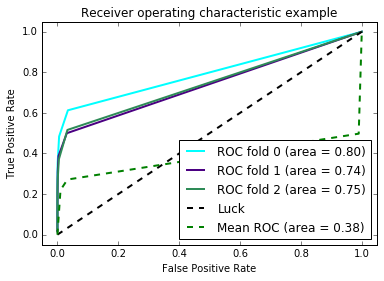

In [166]:
X = sdf.drop(['sequence','allergen'], axis=1)
y = sdf['allergen']
rf = RandomForestClassifier()
cv_score(rf, X, y)
cross_val_roc(rf, X, y)

f1 cross validation score: 0.164130675526


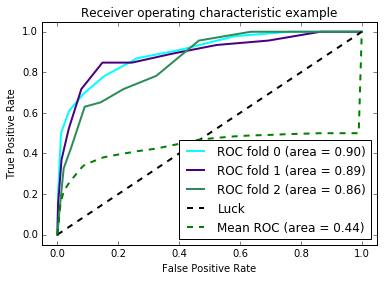

In [173]:
X = sdf.drop(['sequence','allergen'], axis=1)
y = sdf['allergen']
rf = RandomForestClassifier()
cv_score(rf, X, y)
cross_val_roc(rf, X, y, balance=True)

f1 cross validation score: 0.86256660538


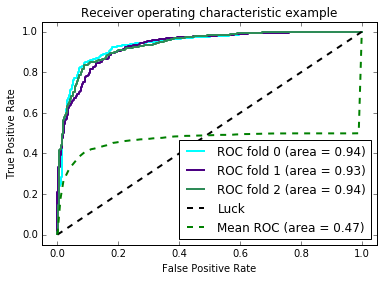

In [176]:
X = balanced_df.drop(['sequence','allergen'], axis=1)
y = balanced_df['allergen']
rf = GradientBoostingClassifier()
cross_val_roc(rf, X, y)
cv_score(rf, X, y)

f1 cross validation score: 0.208391513026


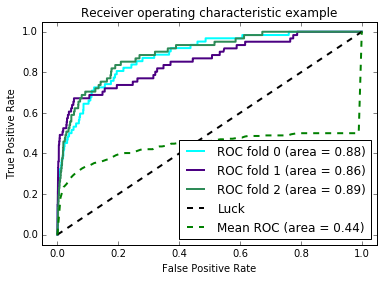

In [177]:
X = sdf.drop(['sequence','allergen'], axis=1)
y = sdf['allergen']
rf = GradientBoostingClassifier()
cv_score(rf, X, y)
cross_val_roc(rf, X, y)

f1 cross validation score: 0.191749566302


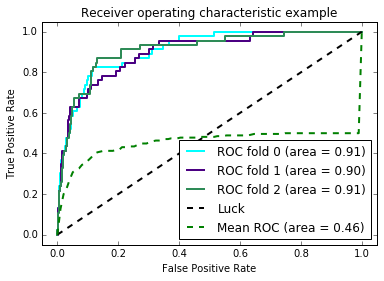

In [178]:
X = sdf.drop(['sequence','allergen'], axis=1)
y = sdf['allergen']
rf = GradientBoostingClassifier()
cv_score(rf, X, y)
cross_val_roc(rf, X, y, balance=True)